<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov  5 16:16:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
# import dataset from kaggle
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d .
clear_output()

In [31]:
import torchvision
transform = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize([32,32]),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize([32,32]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])
}

# no image augmentation
img_path = 'Vegetable Images'
train_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['train'])
valid_set = torchvision.datasets.ImageFolder(f'{img_path}/validation', transform=transform['test'])
test_set = torchvision.datasets.ImageFolder(f'{img_path}/test', transform=transform['test'])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=30, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=30, shuffle=False)

In [32]:
sample_batch = next(iter(train_loader))
label_map = {v:k for k,v in train_set.class_to_idx.items()}
num_classes = len(label_map)

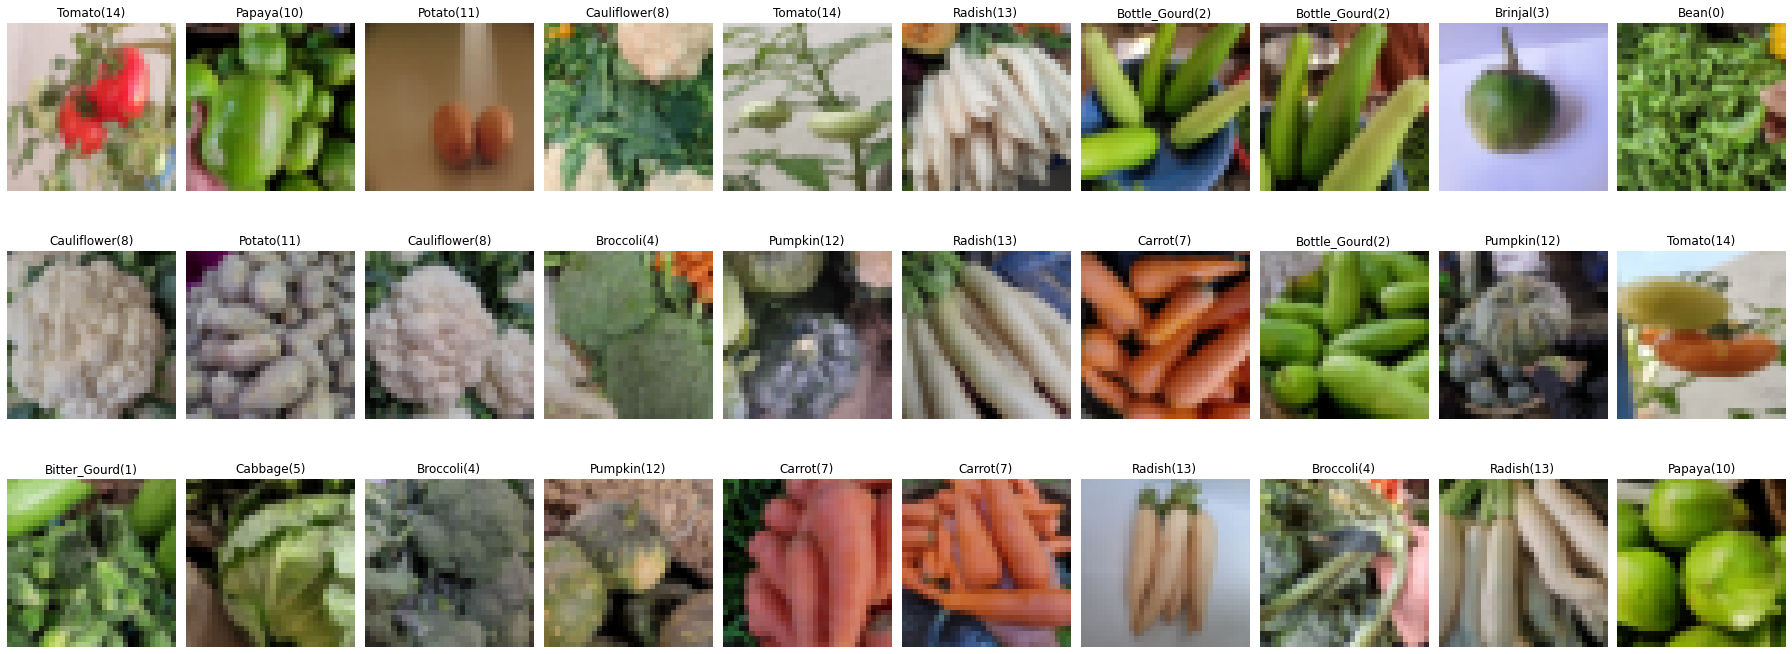

In [45]:
# Random batch visualization
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# create a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch

sample_count = 30
rows = 3
figure, ax = plt.subplots(nrows=rows, ncols=10, figsize=(25, sample_count // rows))

for i, idx in enumerate(range(30)):
    image, label = sample_images[idx], sample_labels[idx]
    image = image / 2 + 0.5
    ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
    title = f'{label_map[sample_labels[idx].item()]}({sample_labels[idx]})'
    ax.ravel()[i].set_title(title)
    ax.ravel()[i].set_axis_off()
    
plt.tight_layout()
plt.show()

In [7]:
import torch
from torch import nn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

In [8]:
# https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var


In [114]:
# Define hyperparameters
n_epoch = 10
weight_decay = 3e-3

batch_size = 30
lr = 1e-4
n_epochs = 30
x_dim = 3072
hidden_dim = 512
latent_dim = 128

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim=x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(n_epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        try:
          x = x.view(batch_size, x_dim)
        except:
          print(x.shape)
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = criterion(x, x_hat)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

Start training VAE...
	Epoch 1 complete! 	Average Loss:  23.484882209833
	Epoch 2 complete! 	Average Loss:  0.011148906007743145
	Epoch 3 complete! 	Average Loss:  0.003017024963755243
	Epoch 4 complete! 	Average Loss:  0.001593515376754466
	Epoch 5 complete! 	Average Loss:  0.000893976982318824
	Epoch 6 complete! 	Average Loss:  0.0004906433234373736
	Epoch 7 complete! 	Average Loss:  0.0004085614974086926
	Epoch 8 complete! 	Average Loss:  0.00023206373354351398
	Epoch 9 complete! 	Average Loss:  0.00014648941186807163
	Epoch 10 complete! 	Average Loss:  8.323444151190964e-05
	Epoch 11 complete! 	Average Loss:  9.477657182838127e-05
	Epoch 12 complete! 	Average Loss:  4.454469790149823e-05
	Epoch 13 complete! 	Average Loss:  2.704829943428004e-05
	Epoch 14 complete! 	Average Loss:  2.904108479228107e-05
	Epoch 15 complete! 	Average Loss:  1.651291342720965e-05
	Epoch 16 complete! 	Average Loss:  1.7675435609493737e-05
	Epoch 17 complete! 	Average Loss:  7.297660507808086e-06
	Epoch 1

  0%|          | 0/100 [00:00<?, ?it/s]


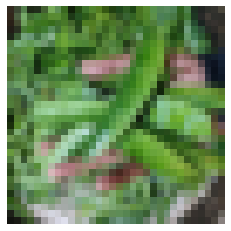

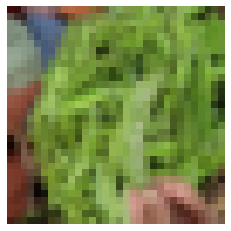

In [113]:
import matplotlib.pyplot as plt
model.eval()

from tqdm import tqdm

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        break

def show_image(x, idx):
    x = (x.view(batch_size, 3, 32, 32) + 1) / 2
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(x[idx].cpu().numpy().transpose(2,1,0))

show_image(x, idx=0)
show_image(x, idx=1)


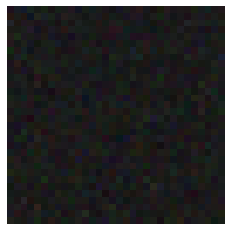

tensor(0.0125, device='cuda:0')

# DCGAN
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# Batch size during training
batch_size = 30

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

  
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)



In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1